In [1]:
import convml_tt
from convml_tt.system import TripletTrainerModel, TripletTrainerDataModule
from convml_tt.data.examples import fetch_example_dataset, ExampleData, fetch_pretrained_model, PretrainedModel
from convml_tt.data.dataset import TileType, ImageSingletDataset
from convml_tt.utils import get_embeddings
import convml_tt.interpretation

import numpy as np
import xarray as xr

import pytorch_lightning as pl

convml_tt.__version__

'v0.5.0+144.g33e0ed5.dirty'

In [2]:
dataset_path = fetch_example_dataset(dataset=ExampleData.LARGE2000S500, data_dir='../../data')
tile_dataset = ImageSingletDataset(data_dir=dataset_path, tile_type=TileType.ANCHOR)

Using downloaded and verified file: ../../data/Nx256_s200000.0_N500study_N2000train.tgz
Extracting ../../data/Nx256_s200000.0_N500study_N2000train.tgz to ../../data


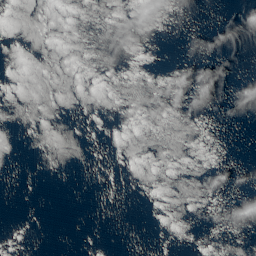

In [4]:
tile_dataset.get_image(index=5)

In [5]:
model_path = fetch_pretrained_model(pretrained_model=PretrainedModel.FIXED_NORM_STAGE2, data_dir="../../")
model = TripletTrainerModel.from_saved_weights(path=model_path)

Using downloaded and verified file: ../../fixednorm-stage-2.tgz
Extracting ../../fixednorm-stage-2.tgz to ../../
Weights loaded from `../../fixednorm-stage-2.torch.pkl`


In [6]:
da_embeddings = get_embeddings(tile_dataset=tile_dataset, model=model)
da_embeddings

100%|██████████| 63/63 [01:55<00:00,  1.83s/it]


<xarray.DataArray (tile_id: 2000, emb_dim: 100)>
array([[-0.00757493, -0.0169627 , -0.01385027, ...,  0.02547195,
         0.00615113, -0.03173376],
       [ 0.01064737, -0.02861817, -0.01345682, ..., -0.00289473,
        -0.02501088,  0.00285347],
       [ 0.00033953,  0.00634394,  0.00487835, ...,  0.0135224 ,
         0.01292639, -0.00501183],
       ...,
       [-0.01168971,  0.02062019,  0.00245582, ..., -0.02098187,
        -0.03549286,  0.01673741],
       [-0.00120012, -0.00231834,  0.0283164 , ..., -0.07895081,
         0.04549999,  0.06307388],
       [ 0.02061721, -0.02799165,  0.02003162, ..., -0.05605858,
         0.03172361,  0.04098912]], dtype=float32)
Coordinates:
  * tile_id  (tile_id) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
Dimensions without coordinates: emb_dim
Attributes:
    data_dir:   /home/earlcd/git-repos/convml_tt/example_notebooks/model_inte...
    tile_type:  ANCHOR
    stage:      train

In [7]:
da_embeddings.to_netcdf("embeddings_example.nc")

# dendrogram

<AxesSubplot:>

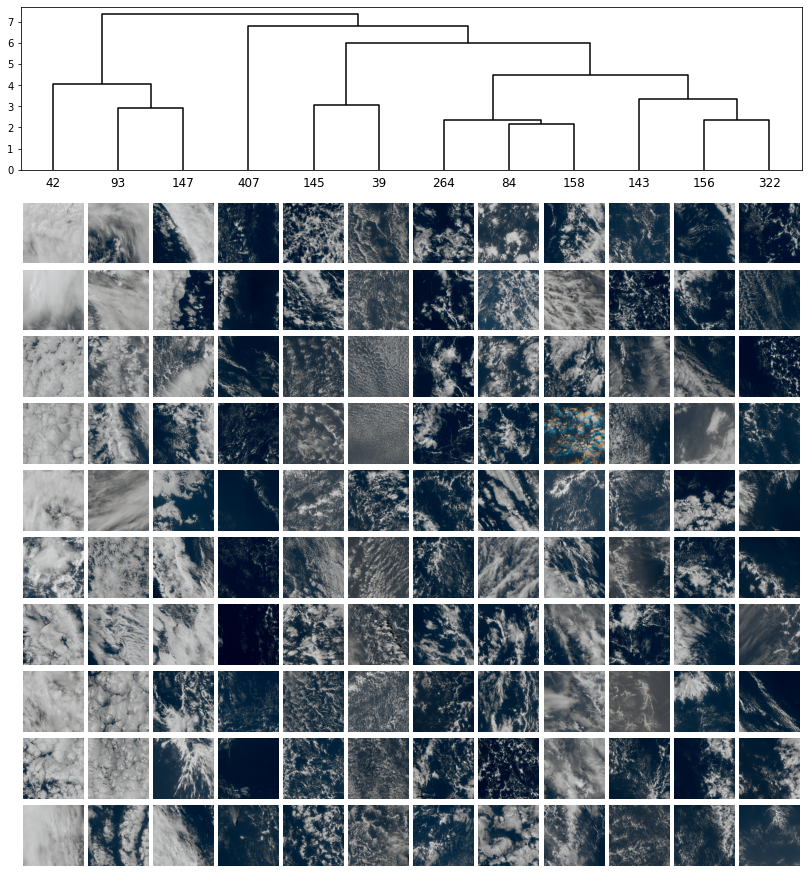

In [8]:
convml_tt.interpretation.plots.dendrogram(da_embeddings, n_samples=10, n_clusters_max=12)

# Annotated scatter plots

In [9]:
import numpy as np
import matplotlib.pyplot as plt

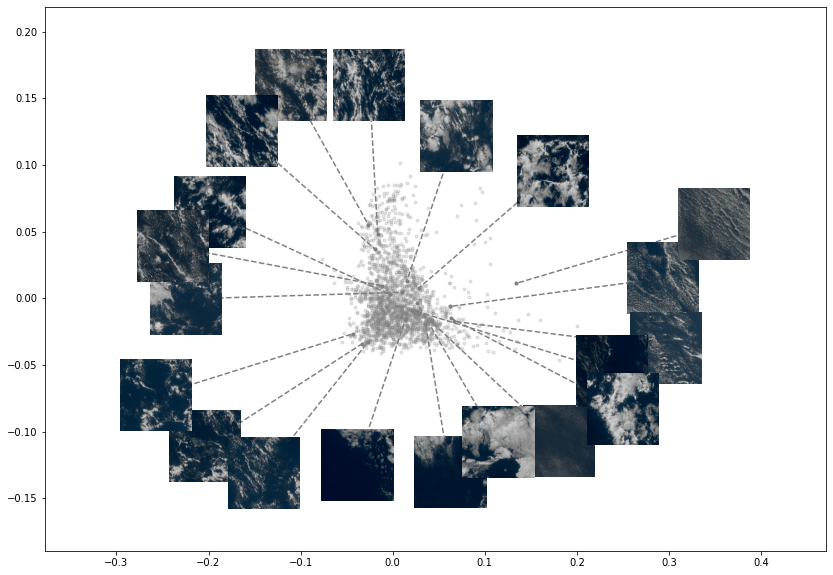

In [10]:
x = da_embeddings.sel(emb_dim=0)
y = da_embeddings.sel(emb_dim=1)
#fig, ax = plt.subplots(figsize=(8,6))
ax = None
_ = convml_tt.interpretation.plots.annotated_scatter_plot(x=x, y=y, points=20, ax=ax)

# plot specific points and annotate with nearest tile¶

IndexError: index -1 is out of bounds for axis 0 with size 0

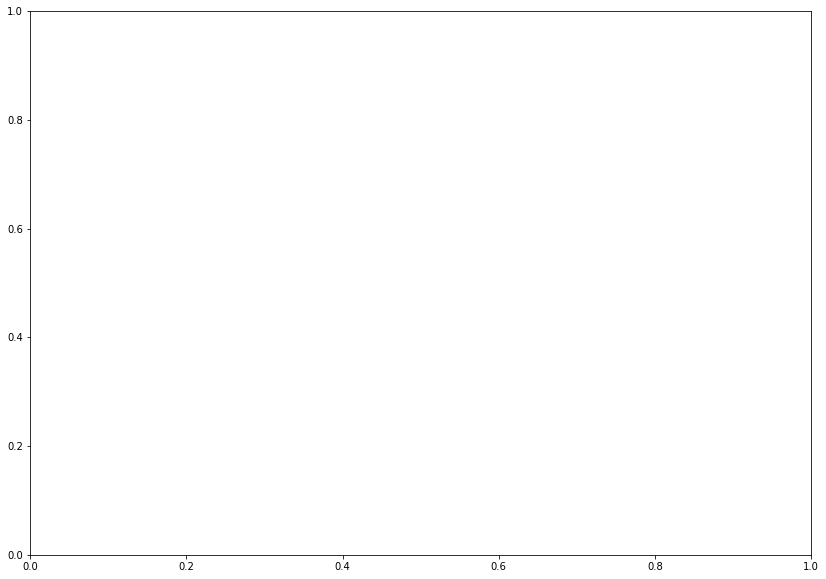

In [11]:
x = da_embeddings.sel(emb_dim=0)
y = da_embeddings.sel(emb_dim=1)

points = (np.array([-0.01, 0., 0.01]), np.array([-0.01, 0., 0.01]))

convml_tt.interpretation.plots.annotated_scatter_plot(x=x, y=y, points=points)

# Grid overview

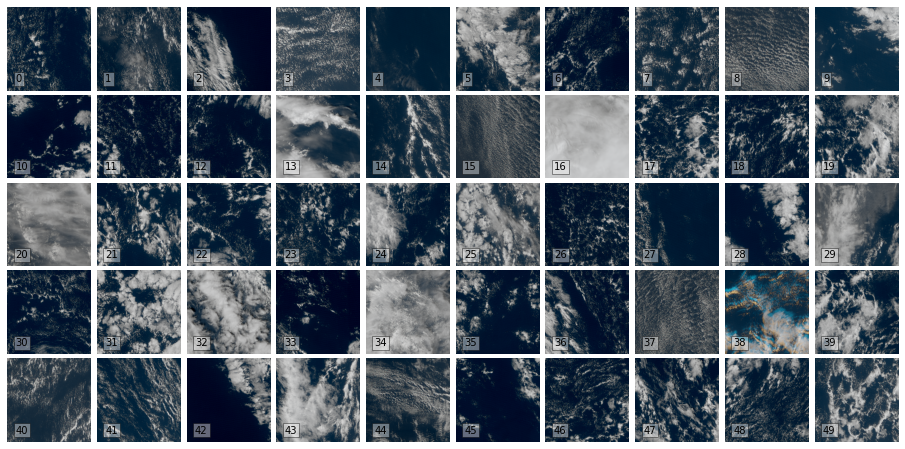

In [12]:
convml_tt.interpretation.plots.grid_overview(tile_dataset, points=50)

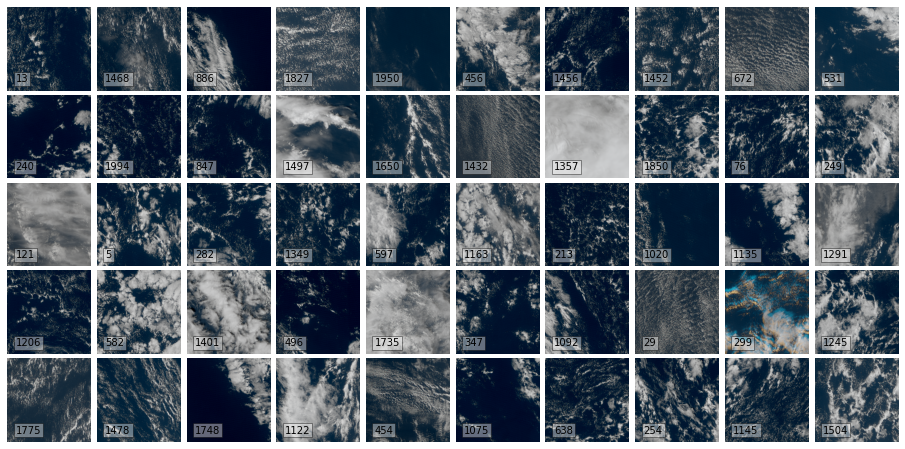

In [13]:
# can be used to for studying a ranking too
def get_dist_to_tile(tile_id, da_):
    dist = np.linalg.norm(da_.sel(tile_id=tile_id) - da_, axis=0)
    return xr.DataArray(dist, coords=dict(tile_id=da_.tile_id), dims=('tile_id',))
    
da_embeddings['dist1'] = get_dist_to_tile(13, da_embeddings)
tile_ids = da_embeddings.sortby('dist1').tile_id.values[:50]

convml_tt.interpretation.plots.grid_overview(tile_dataset, points=tile_ids)